In [1]:
# Required Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import multiprocessing

In [2]:
# Read in data to list
datalist = (os.listdir('final-data/Stab Pos'))
dataset = [pd.read_csv(f'final-data/Stab Pos/{i}').ffill() for i in datalist]

# Remove Unnecessary Columns
dataset = [i.drop(columns=[
    'Baro-Corrected Altitude (ft)',
    'Pressure Altitude (ft)',
    'ENG N1-ACTUAL - LEFT (%RPM)',
    'ENG N1-ACTUAL - RIGHT (%RPM)',
], axis=1) for i in dataset]

# Rename Columns to be more manageable
dataset = [i.rename(columns= {
    'Stab Pos -A/P FCC L (Deg)':'pos_l',
    'Stab Pos -A/P FCC C (Deg)':'pos_c',
    'Stab Pos -A/P FCC R (Deg)':'pos_r',
    'Stab Pos R/C Disagree (Deg)': 'r/c_disagree',
    'Stab Pos L/C Disagree (Deg)': 'l/c_disagree',
    'Stab Pos L/R Disagree (Deg)': 'l/r_disagree'
}) for i in dataset]

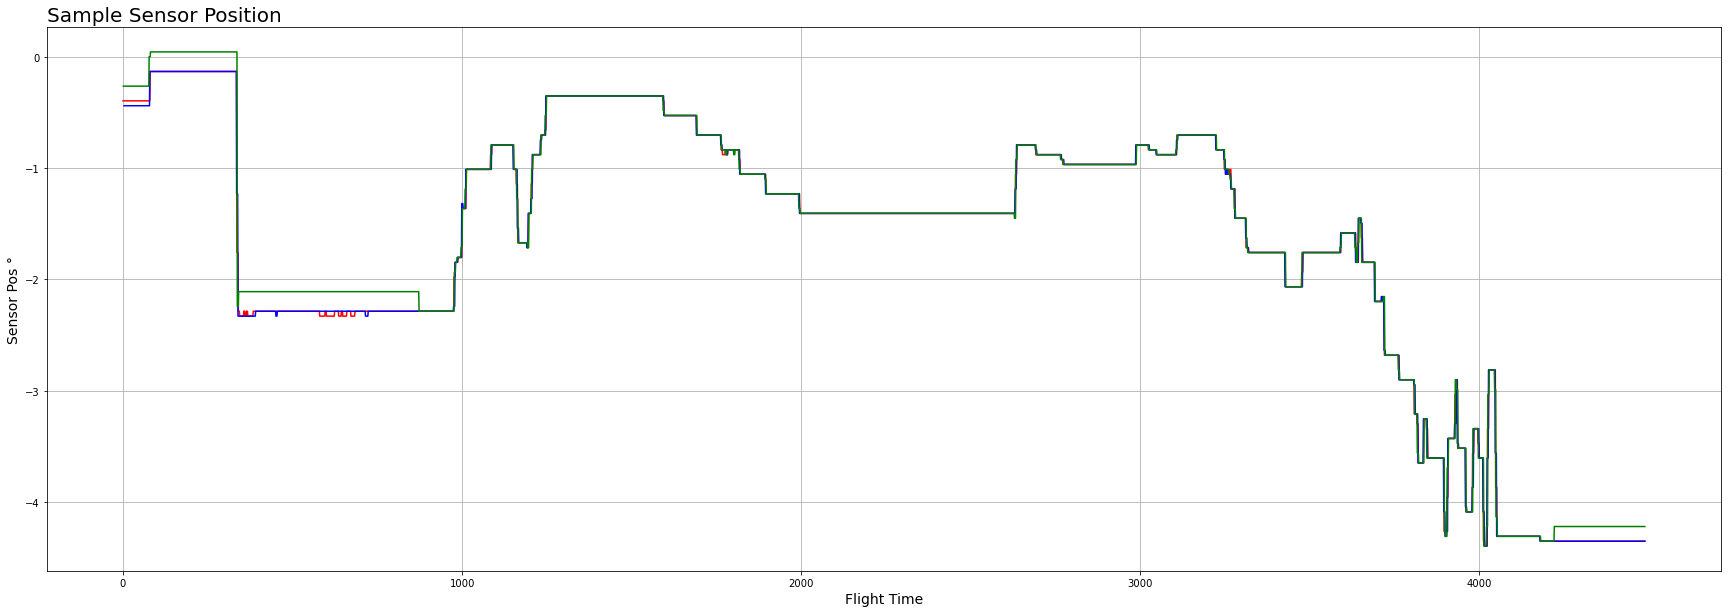

In [3]:
# Plot a sample Dataframe and save plot to file
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(dataset[0]['pos_l'], color='red')
axs.plot(dataset[0]['pos_c'], color='blue')
axs.plot(dataset[0]['pos_r'], color='green')
axs.set_xlabel('Flight Time', size=14)
axs.set_ylabel('Sensor Pos °', size=14)
axs.set_title('Sample Sensor Position', size=20, loc='left')
axs.grid()
plt.savefig('images/Sample Sensor Position.png')

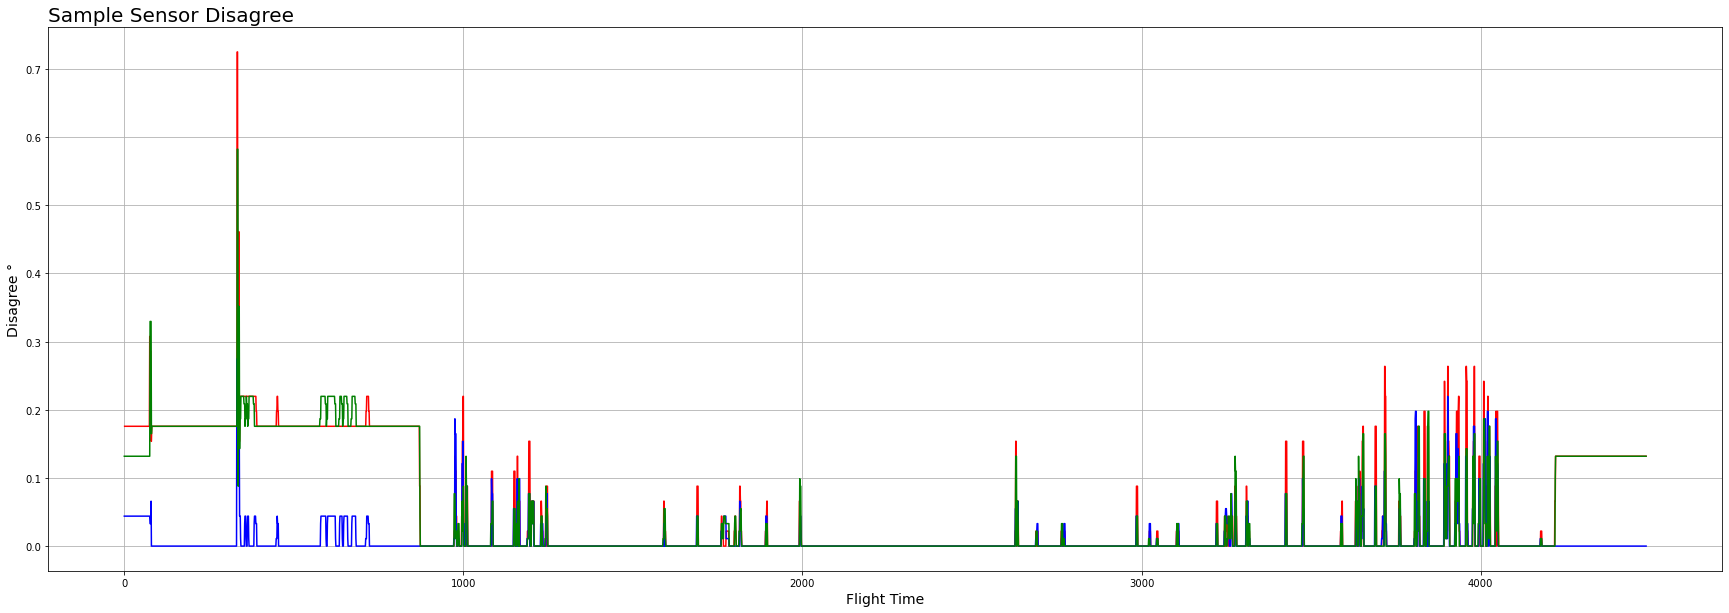

In [4]:
# Plot a sample disagree Dataframe from source and save plot to file
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(dataset[0]['r/c_disagree'], color='red')
axs.plot(dataset[0]['l/c_disagree'], color='blue')
axs.plot(dataset[0]['l/r_disagree'], color='green')
axs.set_xlabel('Flight Time', size=14)
axs.set_ylabel('Disagree °', size=14)
axs.set_title('Sample Sensor Disagree', size=20, loc='left')
axs.grid()
plt.savefig('images/Sample Sensor Disagree.png')

In [5]:
# Returns upper end of Box+Whisker Plot
def get_topend(series):
    q1 = series.quantile(.25)
    q3 = series.quantile(.75)
    iqr = q3-q1
    upper = q3+(1.5*iqr)
    return upper

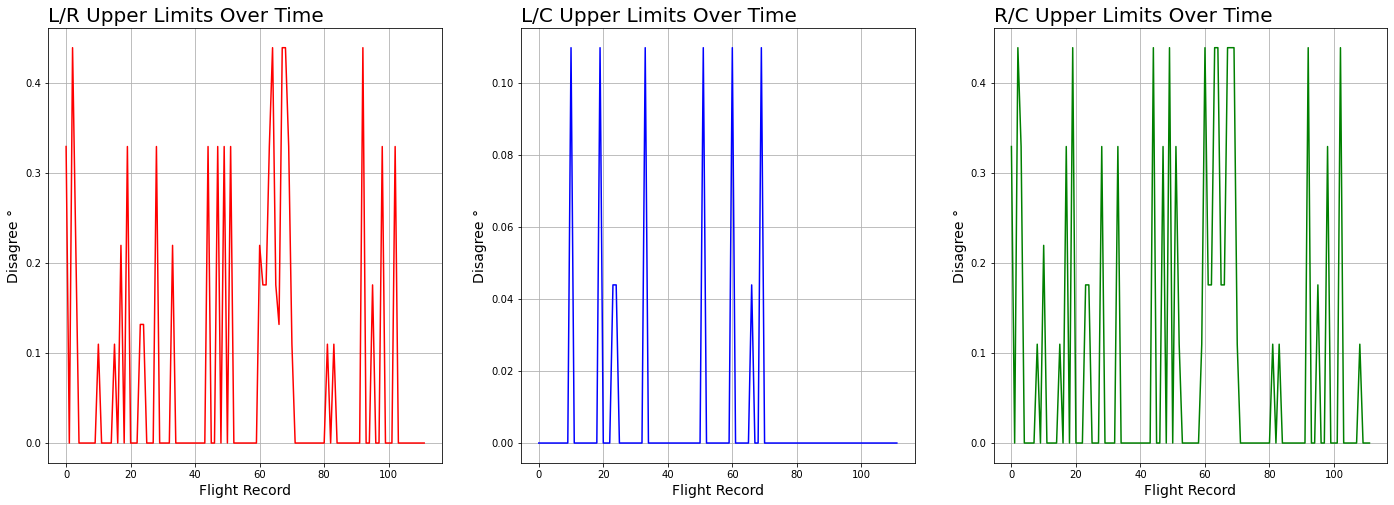

In [6]:
# Find true difference between sensors
for frame in dataset:
    frame['true l/c disagree'] = abs(frame['pos_l']-frame['pos_c'])
    frame['true l/r disagree'] = abs(frame['pos_l']-frame['pos_r'])
    frame['true r/c disagree'] = abs(frame['pos_r']-frame['pos_c'])

# Gathers all true upper ends into a single Dataframe
upper_rc = pd.DataFrame([get_topend(i['true r/c disagree']) for i in dataset])
upper_lc = pd.DataFrame([get_topend(i['true l/c disagree']) for i in dataset])
upper_lr = pd.DataFrame([get_topend(i['true l/r disagree']) for i in dataset])
upperdf = upper_lc
upperdf.rename(columns={0:'upper l/c'}, inplace=True)
upperdf['upper l/r'] = upper_lr
upperdf['upper r/c'] = upper_rc

# Plots upper ends
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
ax1.plot(upperdf['upper l/r'], color='red')
ax2.plot(upperdf['upper l/c'], color='blue')
ax3.plot(upperdf['upper r/c'], color='green')
ax1.set_xlabel('Flight Record', size=14)
ax2.set_xlabel('Flight Record', size=14)
ax3.set_xlabel('Flight Record', size=14)
ax1.set_ylabel('Disagree °', size=14)
ax2.set_ylabel('Disagree °', size=14)
ax3.set_ylabel('Disagree °', size=14)
ax1.set_title('L/R Upper Limits Over Time', size=20, loc='left')
ax2.set_title('L/C Upper Limits Over Time', size=20, loc='left')
ax3.set_title('R/C Upper Limits Over Time', size=20, loc='left')
ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('images/Calculated Sensor Disagree.png');

In [7]:
# Define lists for averages of the outliers
outlier_avg_lr = []
outlier_avg_lc = []
outlier_avg_rc = []

In [8]:
# Create functions for extracting the outliers for all disagree values and appending the average of these
# values to their appropriate lists for all dataframes
def get_outlier_avg_lr(series):
    for frame in dataset:
        outliers_lr = []
        topend = get_topend(frame[series])
        for x in frame[series]:
            if x > topend:
                outliers_lr.append(x)
        if len(outliers_lr) == 0:
            continue
        else:
            outlier_avg_lr.append(sum(outliers_lr)/len(outliers_lr))
            
def get_outlier_avg_lc(series):
    for frame in dataset:
        outliers_lc = []
        topend = get_topend(frame[series])
        for x in frame[series]:
            if x > topend:
                outliers_lc.append(x)
        if len(outliers_lc) == 0:
            continue
        else:
            outlier_avg_lc.append(sum(outliers_lc)/len(outliers_lc))
            
def get_outlier_avg_rc(series):
    for frame in dataset:
        outliers_rc = []
        topend = get_topend(frame[series])
        for x in frame[series]:
            if x > topend:
                outliers_rc.append(x)
        if len(outliers_rc) == 0:
            continue
        else:
            outlier_avg_rc.append(sum(outliers_rc)/len(outliers_rc))

In [9]:
# Attempt to multiprocess all three functions at once
# This process went for roughly 1.75hrs
start = time.time()
p1 = multiprocessing.Process(get_outlier_avg_lr('true l/r disagree'))
p2 = multiprocessing.Process(get_outlier_avg_lc('true l/c disagree'))
p3 = multiprocessing.Process(get_outlier_avg_rc('true r/c disagree'))
p1.start()
p2.start()
p3.start()
end = time.time()
print(int(end - start))

1


In [10]:
# Bring all of the outlier averages into a single dataframe
outlier_avg_lr_df = pd.DataFrame(outlier_avg_lr)
outlier_avg_lc_df = pd.DataFrame(outlier_avg_lc)
outlier_avg_rc_df = pd.DataFrame(outlier_avg_rc)
outlier_avg_df = outlier_avg_lr_df.rename(columns = {0: 'average l/r outliers'})
outlier_avg_df['average l/c outliers'] = outlier_avg_lc_df
outlier_avg_df['average r/c outliers'] = outlier_avg_rc_df

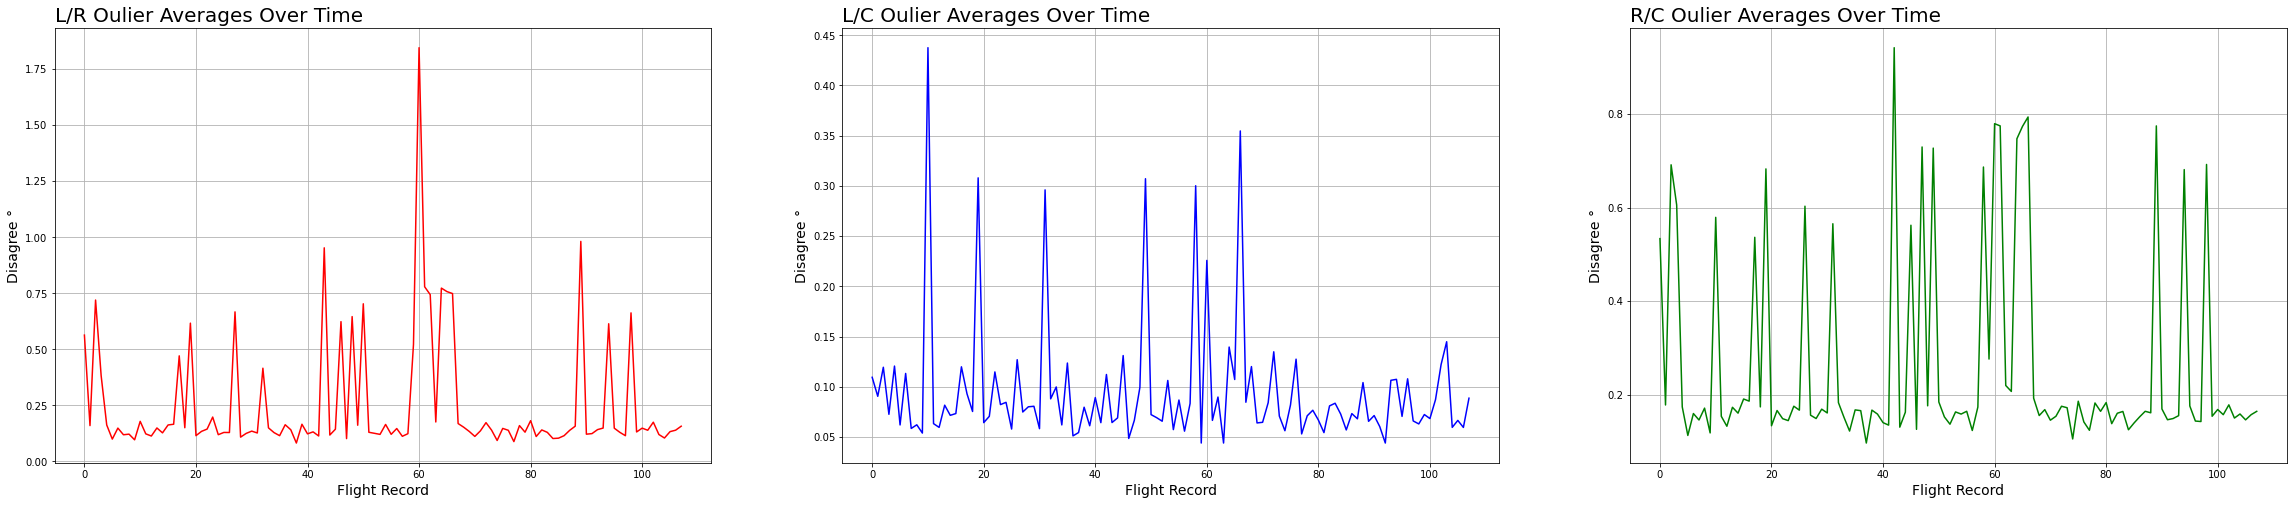

In [11]:
# Plots the outlier averages over time
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (40, 8))
ax1.plot(outlier_avg_df['average l/r outliers'], color='red')
ax2.plot(outlier_avg_df['average l/c outliers'], color='blue')
ax3.plot(outlier_avg_df['average r/c outliers'], color='green')
ax1.set_xlabel('Flight Record', size=14)
ax2.set_xlabel('Flight Record', size=14)
ax3.set_xlabel('Flight Record', size=14)
ax1.set_ylabel('Disagree °', size=14)
ax2.set_ylabel('Disagree °', size=14)
ax3.set_ylabel('Disagree °', size=14)
ax1.set_title('L/R Oulier Averages Over Time', size=20, loc='left')
ax2.set_title('L/C Oulier Averages Over Time', size=20, loc='left')
ax3.set_title('R/C Oulier Averages Over Time', size=20, loc='left')
ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('images/Calculated Outlier Average of Sensor Disagree.png');

In [12]:
outliers_quantile_lr = []
outliers_quantile_lc = []
outliers_quantile_rc = []

In [13]:
# Gets the .75 quantile of all the outlier values for all dataframes
def get_outlier_quantile_lr(series):
    for frame in dataset:
        outliers_lr = []
        topend = get_topend(frame[series])
        for x in frame[series]:
            if x > topend:
                outliers_lr.append(x)
        if len(outliers_lr) == 0:
            continue
        else:
            outliers_quantile_lr.append(pd.DataFrame(outliers_lr).quantile(.75))
            
def get_outlier_quantile_lc(series):
    for frame in dataset:
        outliers_lc = []
        topend = get_topend(frame[series])
        for x in frame[series]:
            if x > topend:
                outliers_lc.append(x)
        if len(outliers_lc) == 0:
            continue
        else:
            outliers_quantile_lc.append(pd.DataFrame(outliers_lc).quantile(.75))
            
def get_outlier_quantile_rc(series):
    for frame in dataset:
        outliers_rc = []
        topend = get_topend(frame[series])
        for x in frame[series]:
            if x > topend:
                outliers_rc.append(x)
        if len(outliers_rc) == 0:
            continue
        else:
            outliers_quantile_rc.append(pd.DataFrame(outliers_rc).quantile(.75))

In [14]:
# Attempt to multiprocess all three functions at once
# This process went for roughly 1.75hrs
start = time.time()
p1 = multiprocessing.Process(get_outlier_quantile_lr('true l/r disagree'))
p2 = multiprocessing.Process(get_outlier_quantile_lc('true l/c disagree'))
p3 = multiprocessing.Process(get_outlier_quantile_rc('true r/c disagree'))
p1.start()
p2.start()
p3.start()
end = time.time()
print(int(end - start))

1


In [15]:
# Bring all of the outlier averages into a single dataframe
outlier_quantile_lr_df = pd.DataFrame(outliers_quantile_lr)
outlier_quantile_lc_df = pd.DataFrame(outliers_quantile_lc)
outlier_quantile_rc_df = pd.DataFrame(outliers_quantile_rc)
outlier_quantile_df = outlier_avg_lr_df.rename(columns = {0: '.75 l/r outliers'})
outlier_quantile_df['.75 l/c outliers'] = outlier_avg_lc_df
outlier_quantile_df['.75 r/c outliers'] = outlier_avg_rc_df

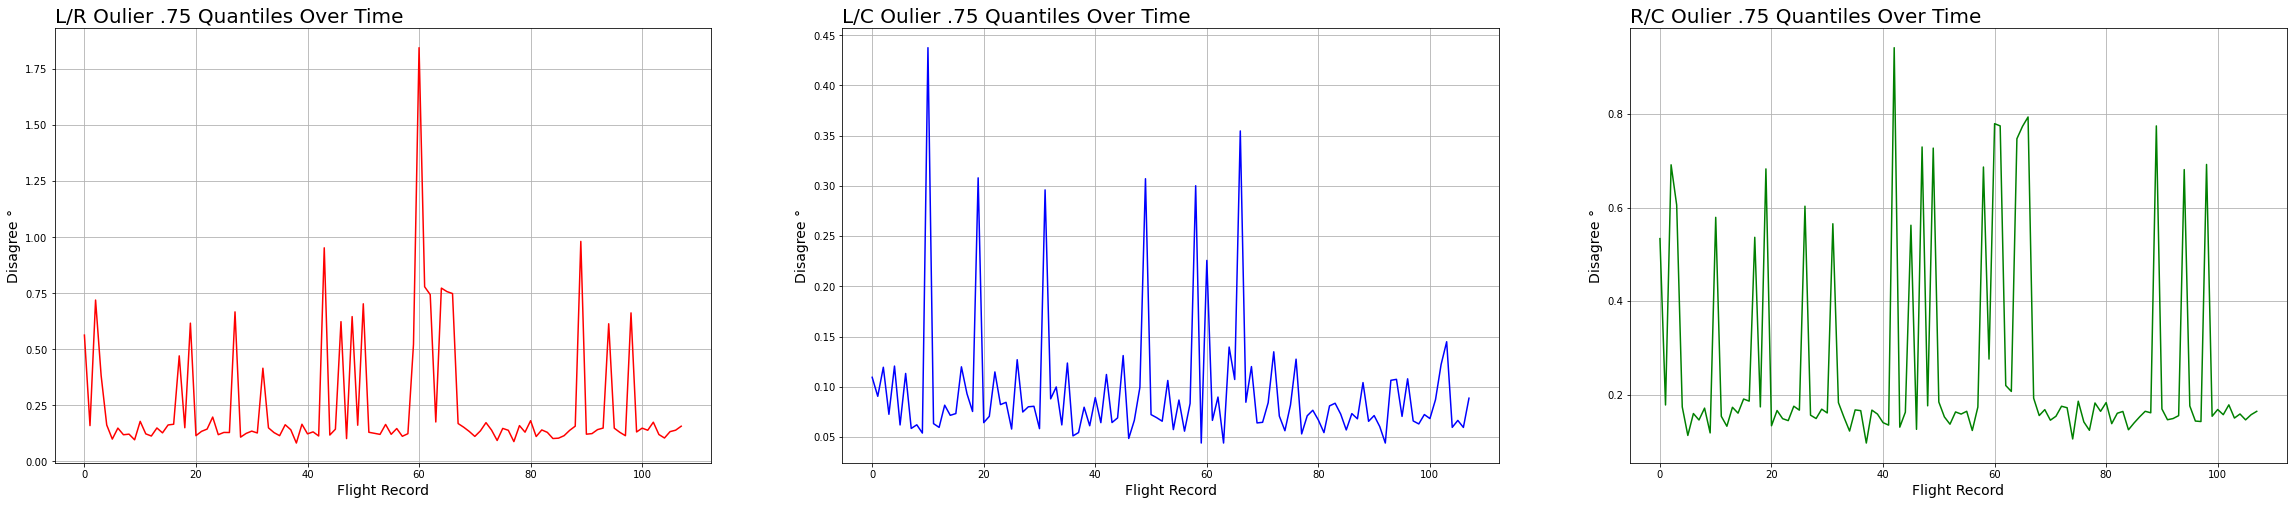

In [16]:
# Plots the .75 quantile over time
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (40, 8))
ax1.plot(outlier_quantile_df['.75 l/r outliers'], color='red')
ax2.plot(outlier_quantile_df['.75 l/c outliers'], color='blue')
ax3.plot(outlier_quantile_df['.75 r/c outliers'], color='green')
ax1.set_xlabel('Flight Record', size=14)
ax2.set_xlabel('Flight Record', size=14)
ax3.set_xlabel('Flight Record', size=14)
ax1.set_ylabel('Disagree °', size=14)
ax2.set_ylabel('Disagree °', size=14)
ax3.set_ylabel('Disagree °', size=14)
ax1.set_title('L/R Oulier .75 Quantiles Over Time', size=20, loc='left')
ax2.set_title('L/C Oulier .75 Quantiles Over Time', size=20, loc='left')
ax3.set_title('R/C Oulier .75 Quantiles Over Time', size=20, loc='left')
ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('images/Calculated Outlier .75 Quantile of Sensor Disagree.png');